## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [2]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [5]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
1022,My question: how do I heal from this? As much ...,1
1162,"Sorry for the ramble, I would like to know if ...",1
16,The sensation lasted hours. It seemed like a c...,1
2587,The problem is one of these guy friends. I'm t...,0
1716,"I have to talk to him and make nice, and prete...",1


In [6]:
df['label'].unique()

array([1, 0], dtype=int64)

In [7]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<Axes: xlabel='label', ylabel='count'>

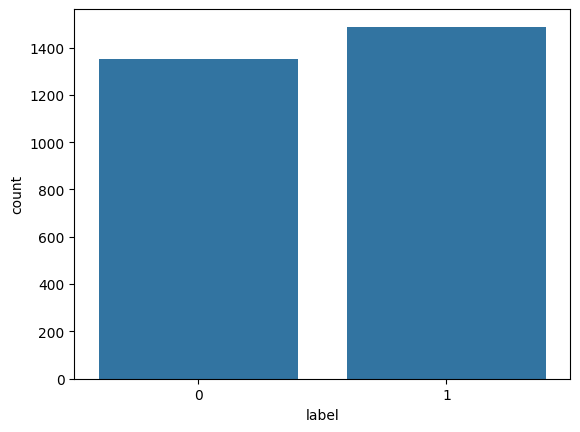

In [8]:
sns.countplot(x='label', data=df)

In [9]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
2264,it is the winter and tyler and i have been goi...,0
1099,"my memory goes, i panic, breakdown, rock back ...",1
2818,she has not once shown disappointment. when sh...,1
1460,he said that i should have ptsd because the re...,1
2101,they’re out of town. i live in a pretty safe n...,1


In [10]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
2543,i started my seizure while on the stairs and a...,0
1993,her gofundme is at url xb any shares you could...,0
77,hello guys this is my first post here ever sin...,1
2657,at the end of the survey please select name wh...,0
671,ive been in the mood since friday night we had...,0
1769,so here's what's going on i'm a fulltime grad...,0
2794,she's a real healer she's beautiful in so many...,0
667,my sister messaged me call me asap i received ...,0
725,yesterday i almost had sex with someone but wh...,1
682,she has a temper and some anger issues i'm the...,0


In [11]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     --------------------------------------- 42.8/42.8 MB 24.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [12]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [13]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [14]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
1196,realized maybe it's better break love he's imp...,0
1030,tainted memories dad doubts grandpa don't cont...,1
1627,anxious waiting room crying babies kids clue t...,1
2141,problem kind surprised time hearing cousin's m...,0
266,hello long long long time user paxil looking t...,0
2558,night staying late uncle watching movies odd w...,0
1185,applied disability currently facing waiting ye...,1
354,eat probiotic food good gut bacteria enhacems ...,0
711,things got better middle school thankfully sad...,1
1089,time school way bigger rooms scattered school ...,1


In [15]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [16]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:14<00:00, 189.94it/s]


,text,label
1158,like contact gon na forced week breakup reach ...,1
1755,laugh loudly couple people surprise stay silen...,0
1666,think sound fun agree way nervous anxious kind...,1
741,stop productive thing talk people remember app...,1
175,I be say do n't enjoy do n't need long story s...,1
770,I be try figure learn good think learn trust i...,1
2195,post spur fact scroll photo take boyfriend yea...,1
2126,apologise thought end get point walk room shel...,0
173,specifically tell father lose money gambling I...,1
870,bother bully school grade start slip ask right...,0


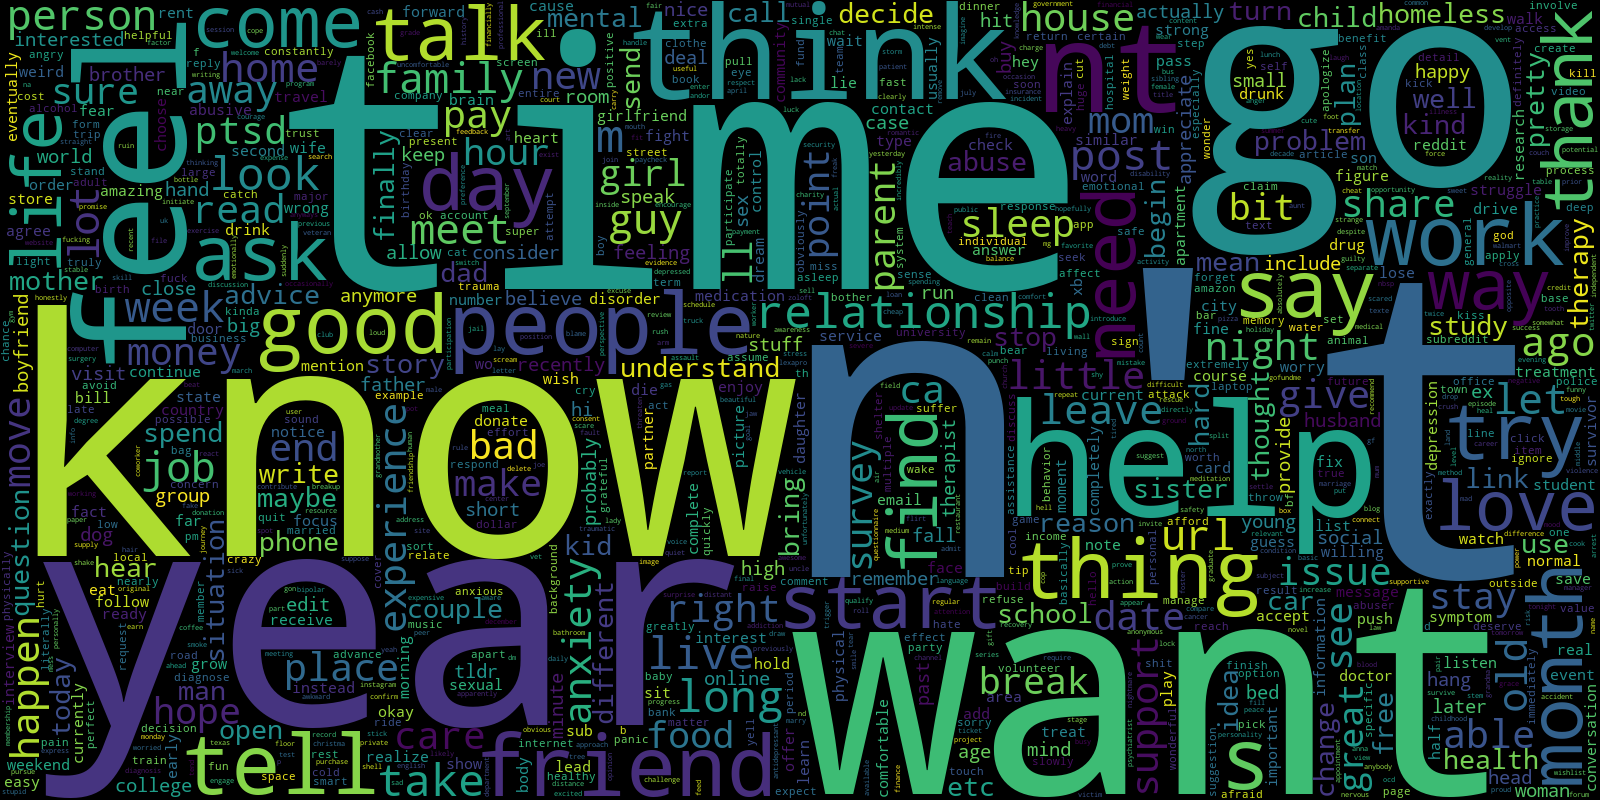

In [17]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

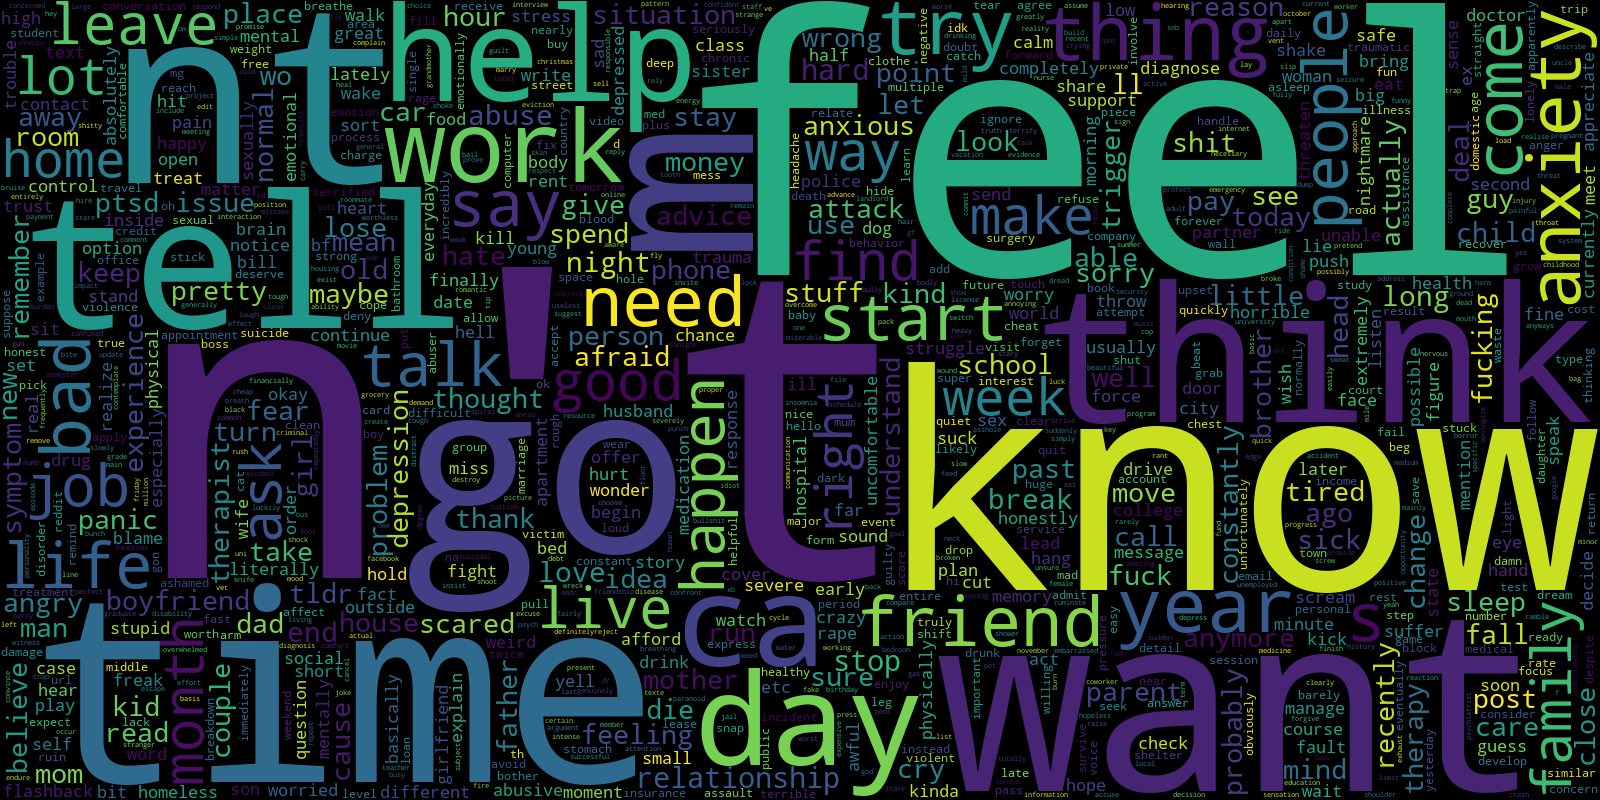

In [18]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.3, random_state=42)

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_tokens)

X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_val_tokens = pad_sequences(X_val_tokens, maxlen=max_len, padding='post')


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

embedding_dim = 50  # wymiar osadzenia słów

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_hist = model.fit(X_train_tokens, y_train, epochs=3, validation_data=(X_val_tokens, y_val))

Epoch 1/3
62/62 [==============================] - 2s 15ms/step - loss: 0.6839 - accuracy: 0.5360 - val_loss: 0.6665 - val_accuracy: 0.6123
Epoch 2/3
62/62 [==============================] - 1s 12ms/step - loss: 0.6053 - accuracy: 0.7373 - val_loss: 0.5914 - val_accuracy: 0.7021
Epoch 3/3
62/62 [==============================] - 1s 12ms/step - loss: 0.4353 - accuracy: 0.8357 - val_loss: 0.5527 - val_accuracy: 0.7104


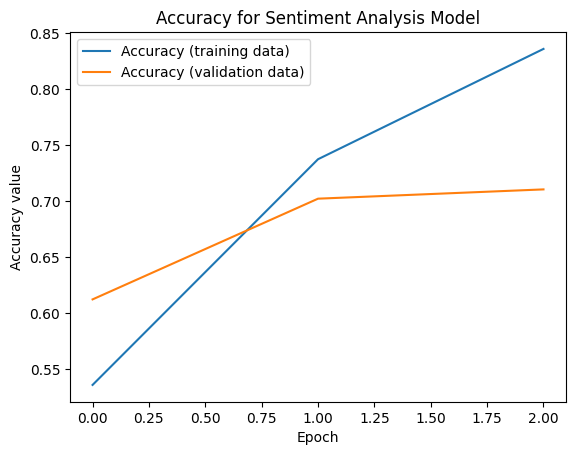

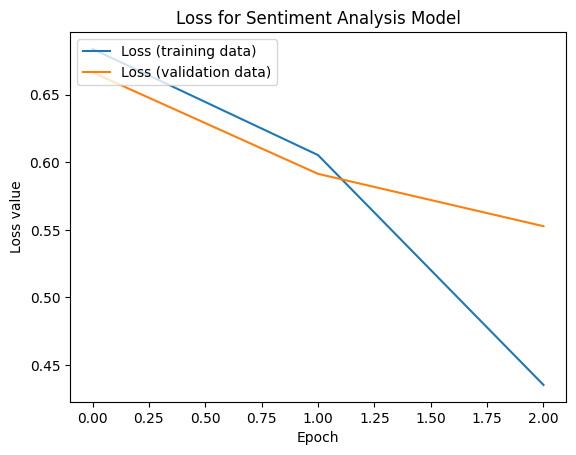

In [23]:
import matplotlib.pyplot as plt

plt.plot(model_hist.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_hist.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_hist.history['loss'], label='Loss (training data)')
plt.plot(model_hist.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [24]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

    return sentence

In [25]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence"
    else:
        return "All good don't sense ANY STRESS in here "

In [26]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model, sentence)
print(result)

1/1 [==============================] - 0s 109ms/step
All good don't sense ANY STRESS in here 
